In [118]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [119]:
PATH = './classifiy_train_data_V4'
train_dir = PATH

train_dir = PATH
class_num = 11

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 7735 files belonging to 11 classes.


In [120]:
train_dataset.class_names , len(train_dataset)

(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '91'], 121)

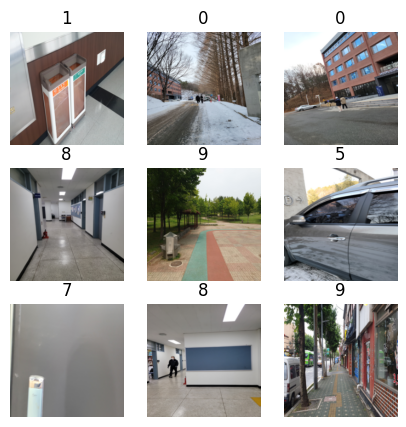

In [121]:
class_names = train_dataset.class_names

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

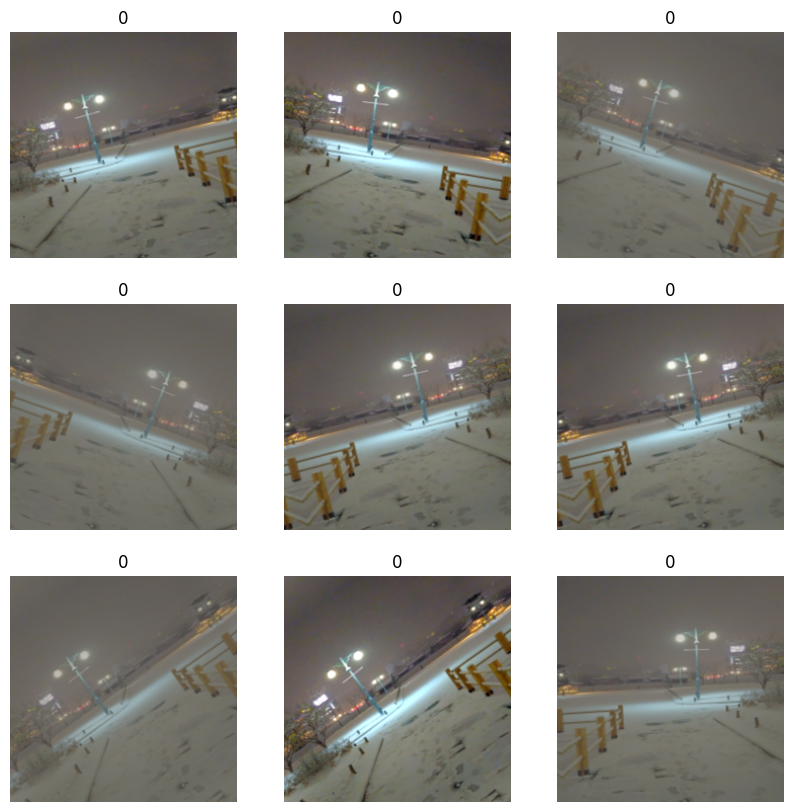

In [122]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomContrast(0.5)
    ]
)

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [123]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input # 전처리가 모델에 포함되어 동작 없음
IMG_SHAPE = IMG_SIZE + (3,)
# Create the base model from the pre-trained model MobileNet V3
base_model = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                               include_top=True,
                                                )
input = base_model.input
outputs = base_model.layers[-5].output  # dropout
new_model = tf.keras.Model(inputs=input, outputs=outputs) 
 # 모바일 넷의 아래 레이어 4개 자른 새로운 모델 생성

In [124]:
image_batch, label_batch = next(iter(train_dataset))
print(image_batch.shape , label_batch)
feature_batch = new_model(image_batch)
print(feature_batch.shape)
feature_batch = tf.keras.layers.Flatten()(feature_batch)
print(feature_batch.shape)
feature_batch = tf.keras.layers.Dense(class_num,activation='softmax')(feature_batch)
print(feature_batch.shape)

(64, 224, 224, 3) tf.Tensor(
[ 3  0  9  2 10  2  9  8  8  9  3  9  3  4  8  3  4  8  9  9  9  8  8  2
  1  0  0  1  0  1  9  0  8  8  2  9  9  0  9  5  9  1  9  5  0  9  9  9
  5  1  0  1  5  2  9  8  0  0  5  2  8  0  9  3], shape=(64,), dtype=int32)
(64, 1, 1, 1024)
(64, 1024)
(64, 11)


In [125]:
len(train_dataset)

121

In [126]:
validation_dataset = train_dataset.take(20) 
train_dataset = train_dataset.skip(20)
len(train_dataset) , len(validation_dataset)

(101, 20)

In [127]:
new_model.trainable = False
prediction_layer = tf.keras.layers.Dense(class_num,activation = 'softmax')

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = new_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 30

loss0, accuracy0 = model.evaluate(validation_dataset)

20/20 [==============================] - 2s 47ms/step - loss: 2.7818 - accuracy: 0.0734


In [128]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.78
initial accuracy: 0.07


In [141]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [130]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1, save_weights_only=False)

In [140]:
#model = keras.models.load_model('./best_model.h5')

In [142]:
with tf.device('/device:GPU:0'): 
  history = model.fit(train_dataset,
                      epochs=50,
                      validation_data=validation_dataset,
                      callbacks=[checkpoint]
                      )
                

Epoch 1/50
100/101 [============================>.] - ETA: 0s - loss: 0.1027 - accuracy: 0.9680
Epoch 1: val_accuracy did not improve from 0.94063
101/101 [==============================] - 10s 68ms/step - loss: 0.1030 - accuracy: 0.9678 - val_loss: 0.2125 - val_accuracy: 0.9289
Epoch 2/50
 99/101 [============================>.] - ETA: 0s - loss: 0.1105 - accuracy: 0.9669
Epoch 2: val_accuracy did not improve from 0.94063
101/101 [==============================] - 8s 62ms/step - loss: 0.1104 - accuracy: 0.9668 - val_loss: 0.2242 - val_accuracy: 0.9312
Epoch 3/50
101/101 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9698
Epoch 3: val_accuracy did not improve from 0.94063
101/101 [==============================] - 8s 62ms/step - loss: 0.1024 - accuracy: 0.9698 - val_loss: 0.2202 - val_accuracy: 0.9305
Epoch 4/50
 99/101 [============================>.] - ETA: 0s - loss: 0.1034 - accuracy: 0.9673
Epoch 4: val_accuracy did not improve from 0.94063
101/101 [======

KeyboardInterrupt: 

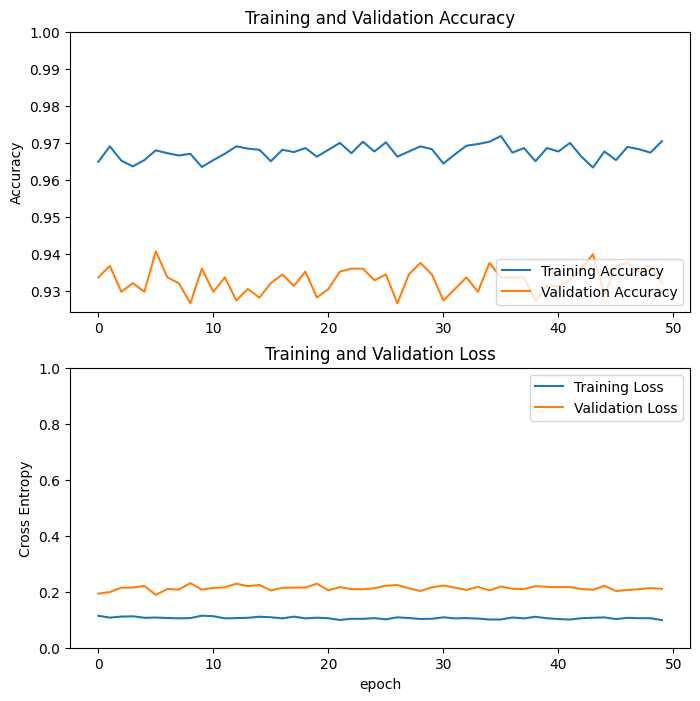

In [143]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [144]:
model.save('./saved_model/final.h5')
tf.saved_model.save(model, './saved_model/final/')
best_model = keras.models.load_model('./best_model.h5')
tf.saved_model.save(best_model, './saved_model/best/')

INFO:tensorflow:Assets written to: ./saved_model/final/assets


INFO:tensorflow:Assets written to: ./saved_model/final/assets


INFO:tensorflow:Assets written to: ./saved_model/best/assets


INFO:tensorflow:Assets written to: ./saved_model/best/assets


In [145]:
# 모델 tflite 로 변환
converter = tf.lite.TFLiteConverter.from_saved_model('./saved_model/best/')
tflite_model = converter.convert()

# Save the model.
with open('final.tflite', 'wb') as f:
  f.write(tflite_model)

In [146]:
import tensorflow as tf
from sklearn.metrics import classification_report

num_classes = 11

# Initialize lists to store the predictions and labels
predictions = []
labels = []

# Iterate over the dataset and make predictions for each batch
for x_batch, y_batch in validation_dataset:
  batch_predictions = model.predict(x_batch)
  predictions.extend(batch_predictions)
  labels.extend(y_batch)


2/2 [==============================] - 0s 8ms/step


In [147]:
np.asarray(labels).shape,np.asarray(predictions).shape

((1280,), (1280, 11))

In [148]:

preds = np.argmax(predictions, axis=1)

In [149]:
np.asarray(labels).shape,np.asarray(preds).shape

((1280,), (1280,))

In [150]:
import numpy as np
report = classification_report(np.asarray(labels),np.asarray(preds))

In [151]:
print(report)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       322
           1       0.86      0.82      0.84        77
           2       0.96      0.87      0.91        55
           3       0.90      0.93      0.92        59
           4       0.90      0.90      0.90        40
           5       0.99      0.98      0.98        81
           6       0.94      0.90      0.92        51
           7       0.87      0.79      0.83        43
           8       0.93      0.96      0.95       253
           9       0.94      0.94      0.94       249
          10       0.98      0.98      0.98        50

    accuracy                           0.94      1280
   macro avg       0.93      0.91      0.92      1280
weighted avg       0.93      0.94      0.93      1280



In [113]:
names = ['./test/야외/', './test/장애물/', './test/나무/', './test/사람/', './test/기둥/', './test/차량/', './test/벽/', './test/문/', './test/실내/', './test/인도/', './test/횡단보도/']
acc = []
for name in names:
    dir = name
    test_dataset = image_dataset_from_directory(dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
    test_loss, test_acc = model.evaluate(test_dataset)
    acc.append(test_acc)

Found 1431 files belonging to 11 classes.
23/23 [==============================] - 2s 53ms/step - loss: 0.0864 - accuracy: 0.9776
Found 449 files belonging to 11 classes.
8/8 [==============================] - 1s 22ms/step - loss: 0.3108 - accuracy: 0.8998
Found 288 files belonging to 11 classes.
5/5 [==============================] - 0s 21ms/step - loss: 0.1829 - accuracy: 0.9583
Found 363 files belonging to 11 classes.
6/6 [==============================] - 0s 24ms/step - loss: 0.0898 - accuracy: 0.9725
Found 198 files belonging to 11 classes.
4/4 [==============================] - 0s 19ms/step - loss: 0.2473 - accuracy: 0.9343
Found 411 files belonging to 11 classes.
7/7 [==============================] - 0s 22ms/step - loss: 0.0144 - accuracy: 0.9976
Found 253 files belonging to 11 classes.
4/4 [==============================] - 0s 25ms/step - loss: 0.2090 - accuracy: 0.9526
Found 253 files belonging to 11 classes.
4/4 [==============================] - 0s 23ms/step - loss: 0.1701 

In [115]:
print(names)
print(acc)

['./test/야외/', './test/장애물/', './test/나무/', './test/사람/', './test/기둥/', './test/차량/', './test/벽/', './test/문/', './test/실내/', './test/인도/', './test/횡단보도/']
[0.9776380062103271, 0.8997772932052612, 0.9583333134651184, 0.9724518060684204, 0.9343434572219849, 0.9975669384002686, 0.9525691866874695, 0.9446640610694885, 0.9864516258239746, 0.9762901067733765, 0.9723076820373535]
